In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import pickle
import os
import string

import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import tqdm as tqdm

from utils.stats import bootstrap_pac_plv_sens,  compute_cohort_binned_plv
from utils.stats import bootstrap_pac_sync_corr, compute_cohort_pac_sync_corr, compute_pac_plv_sens, compute_pac_plv_sens_surr
from utils.colors import okabe, ripples_blue

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
joblib_tmp_dir = 'joblib_temp'

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [5]:
def regplot_with_stats(x, y, ax):
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)
    sns.regplot(x=x, y=y, scatter_kws={'s': 5, 'alpha': 0.5}, line_kws={'lw': 1}, color=ripples_blue, ax=ax)
    ax.annotate(f'$R^2={round(r_value, 2)}$', xy=(0.5, 0.15), xycoords='axes fraction', fontsize=6)

In [6]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')
lags_cycles = np.arange(200)/10

f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

In [7]:
surr_levels = pickle.load(open(os.path.join(submission_data_path, 'figure_6', 'surr_levels.pickle'), 'rb'))

noise_level = surr_levels['pacf_noise_level']
plv_surr_level = surr_levels['plv_surr_level']
wpli_surr_level = surr_levels['wpli_surr_level']
kuramoto_plv_surr_level = surr_levels['kuramoto_plv_surr_level']

In [8]:
seeg_data = pickle.load(open(os.path.join(submission_data_path, 'figure_6', 'seeg_data.pickle'), 'rb'))

pac_plv_bins, cohort_binned_plv = seeg_data['pac_plv_bins'], seeg_data['cohort_binned_plv']
binned_plv = np.nanmean(cohort_binned_plv, axis=0)

spec_surr_mean = seeg_data['spec_surr_mean']
spec_surr_low, spec_surr_high = seeg_data['spec_surr_ci']

seeg_recall_mean = seeg_data['seeg_recall_mean']
seeg_recall_5, seeg_recall_95 = seeg_data['seeg_recall_ci']

surr_pac_sync_corr_mean = seeg_data['surr_pac_sync_corr_mean']
surr_pac_sync_corr_5, surr_pac_sync_corr_95 = seeg_data['surr_pac_sync_corr_ci']

seeg_pac_node_sync_corr_mean = seeg_data['seeg_pac_node_sync_corr_mean']
seeg_pac_node_sync_5, seeg_pac_node_sync_95 = seeg_data['seeg_pac_node_sync_corr_ci']

C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_11620\1398361242.py:4: RuntimeWarning: Mean of empty slice
  binned_plv = np.nanmean(cohort_binned_plv, axis=0)


In [9]:
meg_pac_results_new = pickle.load(open(os.path.join(submission_data_path, 'MEG', 'meg_pac_with_statistics_wpli.pickle'), 'rb'))

meg_recall_boot = bootstrap_pac_plv_sens(meg_pac_results_new['average_pac'], np.abs(meg_pac_results_new['wpli']), np.ones((54, 400, 400), dtype=bool), noise_level, wpli_surr_level, n_rounds=320, n_jobs=16, temp_folder=joblib_tmp_dir, return_sens=False)

meg_recall_mean = np.nanmean(meg_recall_boot, axis=0)
meg_recall_5, meg_recall_95 = np.nanpercentile(meg_recall_boot, (5,95), axis=0)

meg_pac_wpli_bins, meg_binned_wpli = compute_cohort_binned_plv(np.abs(meg_pac_results_new['wpli']), meg_pac_results_new['average_pac'])

In [10]:
kur_reg_data = pickle.load(open(os.path.join(submission_data_path, 'figure_6', 'kuramoto_plv_vs_pac.pickle'), 'rb'))
sim_plv_ticks = kur_reg_data['pac_bins'][:,33].mean(axis=0)

In [11]:
kuramoto_data = pickle.load(open(os.path.join(submission_data_path, 'figure_6', 'kuramoto_pac_plv.pickle'), 'rb'))
kuramoto_cohort_data = pickle.load(open(os.path.join(submission_data_path, 'figure_6','kuramoto_pac_plv_cohort.pickle'), 'rb'))

# _, kur_pac_plv_recall = compute_pac_plv_sens(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool), np.percentile(kuramoto_data['surr'], 99, axis=-1), kuramoto_plv_surr_level)
kur_pac_plv_recall_boot = bootstrap_pac_plv_sens(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool), np.percentile(kuramoto_data['surr'], 99, axis=-1), 
                                                 kuramoto_plv_surr_level, n_rounds=320, n_jobs=16, temp_folder=joblib_tmp_dir, return_sens=False)

kur_recall_mean = kur_pac_plv_recall_boot.mean(axis=0)

kur_recall_5, kur_recall_95 = np.percentile(kur_pac_plv_recall_boot, (5,95), axis=0)

In [12]:
meg_pac_node_sync_corr = compute_cohort_pac_sync_corr(meg_pac_results_new['average_pac'], np.abs(meg_pac_results_new['wpli']), np.ones((54, 400, 400), dtype=bool))
kur_pac_node_sync_corr = compute_cohort_pac_sync_corr(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool))

meg_pac_node_sync_corr = bootstrap_pac_sync_corr(meg_pac_results_new['average_pac'].astype(np.float32), np.abs(meg_pac_results_new['wpli']).astype(np.float32), np.ones((54, 400, 400), dtype=bool), n_jobs=10)
meg_pac_node_sync_5, meg_pac_node_sync_95 = np.percentile(meg_pac_node_sync_corr, (5,95), axis=0)

kur_pac_node_sync_corr = bootstrap_pac_sync_corr(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool), n_jobs=32)
kur_pac_node_sync_5, kur_pac_node_sync_95 = np.percentile(kur_pac_node_sync_corr, (5,95), axis=0)


C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_11620\1185387412.py:31: RuntimeWarning: Mean of empty slice
  imh_wpli = axes[2,2].imshow(np.nanmean(meg_binned_wpli, axis=0)[35], origin='lower', cmap='viridis')


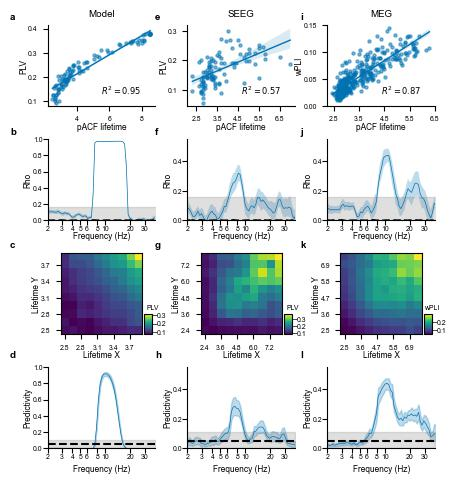

In [13]:
i,j = 7, 30

fig, axes = plt.subplots(figsize=(5, 5.5), ncols=3, nrows=4, dpi=100,  gridspec_kw={'hspace': 0.4, 'wspace':0.3})

cbar_axes = [axes[2,i].inset_axes([1.025, 0.0, 0.1, 0.25]) for i in range(3)]

regplot_with_stats(x=kuramoto_cohort_data['pac'][0,35], y=np.abs(kuramoto_cohort_data['plv'][0, 35]).mean(axis=0), ax=axes[0, 0])
regplot_with_stats(x=seeg_data['example_pacf_lifetime'], y=np.abs(seeg_data['example_cplv']).mean(axis=0), ax=axes[0, 1])
regplot_with_stats(x=meg_pac_results_new['average_pac'][13, 35], y=np.abs(meg_pac_results_new['wpli'][13, 35]).mean(axis=0), ax=axes[0, 2])

axes[1,0].semilogx(f_vals, kur_pac_node_sync_corr.mean(axis=0), lw=0.5)
axes[1,0].fill_between(f_vals, kur_pac_node_sync_5, kur_pac_node_sync_95, alpha=0.25)

axes[1,0].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,0].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

axes[1,1].semilogx(f_vals, seeg_pac_node_sync_corr_mean, lw=0.5)
axes[1,1].fill_between(f_vals, seeg_pac_node_sync_5, seeg_pac_node_sync_95, alpha=0.25)

axes[1,1].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,1].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

axes[1,2].semilogx(f_vals, meg_pac_node_sync_corr.mean(axis=0), lw=0.5)
axes[1,2].fill_between(f_vals, meg_pac_node_sync_5, meg_pac_node_sync_95, alpha=0.25)

axes[1,2].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,2].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

imh_plv_sim = axes[2,0].imshow(np.nanmean(kur_reg_data['plv_binned'][:,33], axis=0), origin='lower')
imh = axes[2,1].imshow(binned_plv[30], origin='lower')
imh_wpli = axes[2,2].imshow(np.nanmean(meg_binned_wpli, axis=0)[35], origin='lower', cmap='viridis')

axes[3,0].semilogx(f_vals, kur_recall_mean, color=ripples_blue, lw=0.5)
axes[3,0].fill_between(f_vals, kur_recall_5, kur_recall_95, color=ripples_blue, alpha=0.25)
axes[3,0].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,0].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

axes[3,1].semilogx(f_vals, seeg_recall_mean, color=ripples_blue, lw=0.5)
axes[3,1].fill_between(f_vals, seeg_recall_5, seeg_recall_95, color=ripples_blue, alpha=0.25)
axes[3,1].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,1].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

axes[3,2].semilogx(f_vals, meg_recall_mean, color=ripples_blue, lw=0.5)
axes[3,2].fill_between(f_vals, meg_recall_5, meg_recall_95, color=ripples_blue, alpha=0.25)
axes[3,2].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,2].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

fig.colorbar(imh_plv_sim, cax=cbar_axes[0], orientation='vertical')
fig.colorbar(imh, cax=cbar_axes[1], orientation='vertical')
fig.colorbar(imh_wpli, cax=cbar_axes[2], orientation='vertical')

for ax, ticks in zip(axes[2], [sim_plv_ticks*4, pac_plv_bins[:,30].mean(axis=0), meg_pac_wpli_bins[:,35].mean(axis=0)]):
    ax.set_xticks(np.arange(10)[::2], labels=np.round(ticks[::2], 2).round(1))
    ax.set_yticks(np.arange(10)[::2], labels=np.round(ticks[::2], 2).round(1))

for ax, ylabel, title in zip(axes[0], ['PLV', 'PLV', 'wPLI'], ['Model', 'SEEG', 'MEG']):
    ax.set_ylabel(ylabel, fontsize=6, labelpad=0.1)
    ax.set_xlabel('pACF lifetime', fontsize=6, labelpad=0.1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(title, fontsize=7)
    
for ax in axes[2]:
    ax.set_xlabel('Lifetime X', fontsize=6, labelpad=0.1)
    ax.set_ylabel('Lifetime Y', fontsize=6, labelpad=0.1)


for ax, ymax in zip(axes[3], [1.0, 0.55, 0.55]):
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.set_xticks([2,3,4,5,6,8,10,20,30])
    
    ax.set_xlim([f_vals[0], 40])
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    ax.set_ylabel('Predictivity', fontsize=6, labelpad=0.1)
    
    ax.set_ylim([-0, ymax])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(pad=0.1)

for ax, ymax in zip(axes[1], [1.0, 0.55, 0.55]):
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.set_xticks([2,3,4,5,6,8,10,20,30])
    
    ax.set_xlim([f_vals[0], 40])
    ax.set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0.1)
    ax.set_ylabel('Rho', fontsize=6, labelpad=0.1)
    
    ax.set_ylim([-0, ymax])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(pad=0.1)
    
# axes[0,0].set_xlim([2.25, 4])
# axes[0,0].set_ylim([0.1, 0.16])

axes[0,2].set_ylim([0.0, 0.15])

axes[0,1].set_xticks([2.5, 3.5, 4.5, 5.5, 6.5])
axes[0,2].set_xticks([2.5, 3.5, 4.5, 5.5, 6.5])

for ax in axes.flatten().tolist() + cbar_axes:
    ax.tick_params(labelsize=5)

for ax, label in zip(cbar_axes, ['PLV', 'PLV', 'wPLI']):
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.set_title(label, fontsize=5, x=1.1, y=0.8)

for label, (xpos, ypos) in zip(string.ascii_lowercase, itertools.product([0.05, 0.34, 0.63], [0.89, 0.68, 0.475, 0.275])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_6.png', dpi=300, bbox_inches='tight')

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_6.{format}', dpi=300, bbox_inches="tight")